# Neuronky projekt 1

In [1]:
using PyPlot
using PyCall
@pyimport math as m
using DataFrames

## Functions

In [2]:
# K-CROSS VALIDATION

function kcross(data, N, K=8, k=1)
  
    ratio = 1/K    
    N_val = Int(floor(N*ratio));
    N_train = N - N_val;
    
    val_set = zeros([0 0 0])
    train_set  = zeros([0 0 0])   
    
    for i=1:N
        if ((k-1)*N_val)<i<(k*N_val + 1)
                val_set = [val_set; data[i,:]'];
        else
            train_set = [train_set; data[i,:]'];
        end
    end
    
    val_set = val_set[2:end,:]
    train_set = train_set[2:end,:]
    
    return train_set, val_set, N_train, N_val;
end


# CLASSIFICATION FUNCTIONS

function encode(class)   
    d = zeros(3);
        d[Int(class)] = 1;
    return d
end
   
function decode(d)
    class = float(indmax(d));
    return class;
end

activ(X) = 1 ./ (1 + exp(-X));
deactiv(X) = activ(X) .* (1 - activ(X));
#activ(X) = tanh(X);
#deactiv(X) = 1 - tanh(X).*tanh(X);


# PROPAGATION

function forward(x, W_in, W_out)
    
    x = [x; 1];
    a = W_in * x;
    h = [activ(a); 1];
    b = W_out * h;
    y = activ(b);
    
    return a, h, b, y;
end


function backprop(x, a, h, b, y, d, W_in, W_out, Delta_in, Delta_out, α, λ, M);
    
    g_out = (y - d) .* deactiv(b);
    g_hid = ( ( W_out[:,1:end-1] )' * g_out ) .* deactiv(a);
    dW_out = g_out * h';
    x = [x; 1];
    dW_in = g_hid * x';
    
    Delta_in = α * dW_in + M * Delta_in + λ * W_in;
    Delta_out = α * dW_out + M * Delta_out + λ * W_out;

    return Delta_in, Delta_out;
end

# VISUALIZATION

function visual(data, N)
    figure(figsize=(5,2.5))
    for class=1:3
    set = [0 0];
        for i = 1:N
            if data[i,3] == class
                set = [set; data[i,1:2]' ];
            end
        end
        set = set[2:end,:];
    scatter(set[:,1], set[:,2], 10, colors())
    end
    show()
end

visual (generic function with 1 method)

## Data import and preprocessing

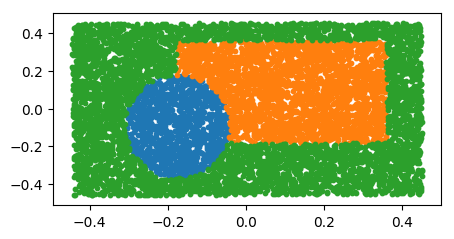

In [3]:
# import & changing classes ABC -> 123

full_set = readtable("train.dat", separator = ' ', header=false, skipstart=1);
full_set = convert(Array, full_set);

(N_full, dim) = size(full_set);
dim_in = dim - 1;
dim_out = 3;

for i=1:N_full
    if full_set[i,3] == "A"
        full_set[i,3] = 1;
    elseif full_set[i,3] == "B"
        full_set[i,3] = 2;
    else
        full_set[i,3] = 3;
    end
end
full_set = Array{Float64}(full_set);


# scaling & decorrelating

Xmean = mean(full_set[:,1]);
Ymean = mean(full_set[:,2]);
        
full_set[:,1] = (full_set[:,1] - Xmean) / ( maximum(full_set[:,1]) - minimum(full_set[:,1]) );
full_set[:,2] = (full_set[:,2] - Ymean) / ( maximum(full_set[:,2]) - minimum(full_set[:,2]) );

k = 0.1/0.85
l = 0.09/0.85

full_set[:,1] = full_set[:,1] - full_set[:,2] * k;
full_set[:,2] = full_set[:,2] - full_set[:,1] * l;

# initial vizualization

visual(full_set, N_full)

## Training and Validation

In [15]:
## MAIN FUNCTION

function main(train_set, N_train, val_set, N_val, epochs, dim_hid, α, λ, M, delay)

    #Initialisation
    
    W_in = 0.01*( 2*rand(dim_hid, dim_in + 1) - 1)
    W_out = 0.01*( 2*rand(dim_out, dim_hid + 1) - 1)

    Trainclass = zeros(N_val);   #Final classes

    TE = zeros(epochs)            #Train error
    TCE = zeros(epochs)           #Train class error
    VE = zeros(epochs)            #Validation error
    VCE = zeros(epochs)           #Validation class error

    
    
    # BEGIN

    for n = 1:epochs
        if mod(n, delay) == 0  println("Starting epoch $n ") end

        Error = 0
        ClassError = 0
        
        Delta_in = zeros(dim_hid, dim_in + 1)
        Delta_out = zeros(dim_out, dim_hid + 1)

    ####### TRAINING #######

        for i = randperm(N_train)

            x = train_set[i,1:2]
            d = encode(train_set[i,3])

            (a, h, b, y) = forward(x, W_in, W_out)

            (Delta_in, Delta_out) =
            backprop(x, a, h, b, y, d, W_in, W_out, Delta_in, Delta_out, α, λ, M)

            W_in -= Delta_in
            W_out -= Delta_out


            if decode(d) != decode(y)
                ClassError += 1
            end

            Error += mean( (d - y).^2 )    # quadratic error
        end

        ClassError /= N_train
        Error = (Error + λ*( sum(W_in[:,1].*W_in[:,1]) + sum(W_out[:,1:dim_hid].*W_out[:,1:dim_hid])) )/ N_train

        TE[n] = Error
        TCE[n] = ClassError

        if mod(n, delay) == 0  println("ClassError = $(round(100*ClassError)) %") end

    ####### Validation #######

        Error = 0
        ClassError = 0

        for i = 1:N_val

            x = val_set[i,1:2]
            d = encode(val_set[i,3])

            (a, h, b, y) = forward(x, W_in, W_out)
            
            if n==epochs  Trainclass[i] = decode(y) end
            
            if decode(d) != decode(y)
                ClassError += 1;
            end

            Error += mean( (d - y).^2 )
        end

        ClassError /= N_val;
        Error /= N_val;

        VE[n] = Error;
        VCE[n] = ClassError;

        if mod(n, delay) == 0  println("Error = $Error") end
        
        if n == epochs
            println("Final ValError = $Error")
            println("Final ClassError = $(round(100*ClassError)) %")
        end
        
    end 
    
    return TE, TCE, VE, VCE, Trainclass;
end

main (generic function with 3 methods)

## MAIN

Training... 
Starting epoch 50 
ClassError = 4.0 %
Error = 0.020468370973978717
Starting epoch 100 
ClassError = 3.0 %
Error = 0.016109321037271723
Starting epoch 150 
ClassError = 2.0 %
Error = 0.012857860125418582
Starting epoch 200 
ClassError = 2.0 %
Error = 0.011186386853031749
Starting epoch 250 
ClassError = 2.0 %
Error = 0.009722262557360995
Starting epoch 300 
ClassError = 2.0 %
Error = 0.00930125999268635
Final ValError = 0.00930125999268635
Final ClassError = 2.0 %


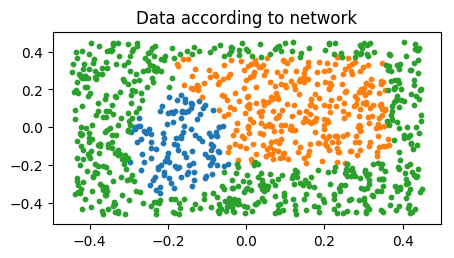

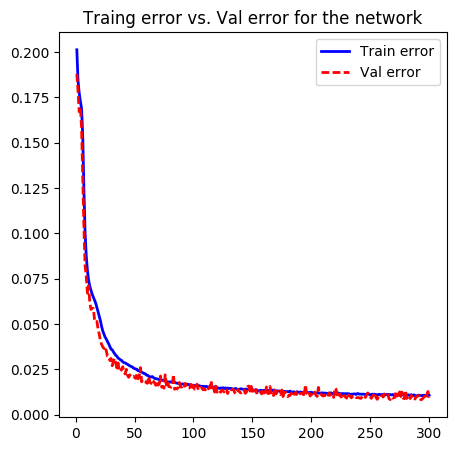

Finish


In [17]:
# Parameters

α = 0.2
λ = 0
M = 0.002

dim_hid = 30    
epochs = 300

delay = 50

TCEset = [0];
VCEset = [0];

# mixing
full_set = full_set[randperm(N_full), :]

# K-cross validation

K=8
for k=3
    
    println("Training... ")
    (train_set, val_set, N_train, N_val) = kcross(full_set, N_full, K, k)
    
    (TE, TCE, VE, VCE, Trainclass) = main(train_set, N_train, val_set, N_val, epochs, dim_hid, α, λ, M, delay)
    
    TCEset = [TCEset; 100*TCE[end]]
    VCEset = [VCEset; 100*VCE[end]]
    
    
    if k==3
        result_set = val_set[:,:]
        result_set[:,3] = Trainclass
        
        visual(result_set, N_val)
        title("Data according to network")
        #savefig("Dataxxx.pdf")
    
        n = linspace(1,epochs,epochs);
        figure(figsize=(5,5)); plot(n, TE, color="blue", linewidth=2.0)
                               plot(n, VE, color="red", linewidth=2.0, linestyle="--")
                               title("Traing error vs. Val error for the network")
                               legend(["Train error", "Val error"], loc=1)
                               #savefig("Besterrors.pdf")
    end
end
println("Finish")


## Test set

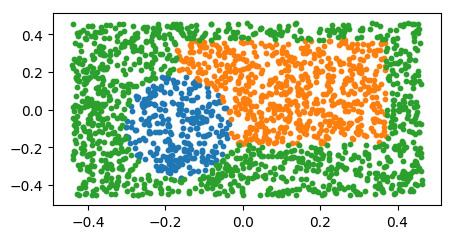

In [13]:
# import & changing classes ABC -> 123

test_set = readtable("test.dat", separator = ' ', header=false, skipstart=1);
test_set = convert(Array, test_set);

(N_test, dim) = size(test_set);

for i=1:N_test
    if test_set[i,3] == "A"
        test_set[i,3] = 1;
    elseif test_set[i,3] == "B"
        test_set[i,3] = 2;
    else
        test_set[i,3] = 3;
    end
end
test_set = Array{Float64}(test_set);


# scaling & decorrelating

Xmean = mean(test_set[:,1]);
Ymean = mean(test_set[:,2]);
        
test_set[:,1] = (test_set[:,1] - Xmean) / ( maximum(test_set[:,1]) - minimum(test_set[:,1]) );
test_set[:,2] = (test_set[:,2] - Ymean) / ( maximum(test_set[:,2]) - minimum(test_set[:,2]) );

k = 0.1/0.85
l = 0.09/0.85

test_set[:,1] = test_set[:,1] - test_set[:,2] * k;
test_set[:,2] = test_set[:,2] - test_set[:,1] * l;

visual(test_set, N_test)